In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

2022-12-01 17:02:32.970748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-01 17:02:33.071578: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-01 17:02:33.074648: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-01 17:02:33.074660: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at /home/patrickreiser/.kgcnn/datasets
INFO:kgcnn.data.download:Downloading dataset... 
INFO:kgcnn.data.download:Creating directory... 
INFO:kgcnn.data.download:Read tar file... 
INFO:kgcnn.data.download:Extracting tar file... 


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1) - np.mean(data.get("energies"))
eng.shape

(500, 1)

In [17]:
from kgcnn.scaler.force import EnergyForceExtensiveScaler
scaler = EnergyForceExtensiveScaler(standardize_coordinates=False, standardize_scale=False)

NotImplementedError: Scaling of coordinates is not yet supported.

In [7]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})
forces.shape

TensorShape([500, None, 3])

In [8]:
from kgcnn.model.force import EnergyForceModel

In [9]:
model = EnergyForceModel(
    module_name="kgcnn.literature.Schnet", 
    class_name="make_model", 
    config={
        "name": "Schnet",
        "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                   {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                   {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
        "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
        "make_distance": True, "expand_distance": True,
        "interaction_args": {"units": 128, "use_bias": True,
                             "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
        "node_pooling_args": {"pooling_method": "sum"},
        "depth": 4,
        "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
        "verbose": 10,
        "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                     "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
        "output_embedding": "graph", "output_to_tensor": True,
        "use_output_mlp": True,
        "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                       "activation": ["kgcnn>shifted_softplus", "linear"]}},
    output_to_tensor=False,
    output_squeeze_states=True,
)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [10]:
x_tensor = data.tensor(model.model_config["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [11]:
test_out = model.predict(x_tensor)

16/16 [==============================] - 2s 32ms/step


In [14]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [11]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [12]:
model.compile(
    loss=["mean_absolute_error", RaggedMeanAbsoluteError()],
    optimizer=Adam(learning_rate=5e-04),
    metrics=[],
    loss_weights=[1, 1],
)

hist = model.fit(
    x_tensor, [eng, forces],
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 9s - loss: 26.5522 - output_1_loss: 4.7697 - output_2_loss: 21.7825 - 9s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 26.5453 - output_1_loss: 4.7631 - output_2_loss: 21.7822 - 526ms/epoch - 66ms/step
Epoch 3/1500
8/8 - 1s - loss: 26.5436 - output_1_loss: 4.7614 - output_2_loss: 21.7822 - 527ms/epoch - 66ms/step
Epoch 4/1500
8/8 - 1s - loss: 26.5465 - output_1_loss: 4.7644 - output_2_loss: 21.7821 - 523ms/epoch - 65ms/step
Epoch 5/1500
8/8 - 1s - loss: 26.5464 - output_1_loss: 4.7644 - output_2_loss: 21.7820 - 527ms/epoch - 66ms/step
Epoch 6/1500
8/8 - 1s - loss: 26.5421 - output_1_loss: 4.7602 - output_2_loss: 21.7819 - 520ms/epoch - 65ms/step
Epoch 7/1500
8/8 - 1s - loss: 26.5429 - output_1_loss: 4.7612 - output_2_loss: 21.7817 - 524ms/epoch - 66ms/step
Epoch 8/1500
8/8 - 1s - loss: 26.5430 - output_1_loss: 4.7616 - output_2_loss: 21.7815 - 519ms/epoch - 65ms/step
Epoch 9/1500
8/8 - 1s - loss: 26.5516 - output_1_loss: 4.7711 - output_2_loss: 21.7805 - 524ms/epoch - 66ms/step
E

8/8 - 1s - loss: 25.5814 - output_1_loss: 4.4427 - output_2_loss: 21.1387 - 522ms/epoch - 65ms/step
Epoch 74/1500
8/8 - 1s - loss: 25.5435 - output_1_loss: 4.4723 - output_2_loss: 21.0712 - 519ms/epoch - 65ms/step
Epoch 75/1500
8/8 - 1s - loss: 25.4850 - output_1_loss: 4.6610 - output_2_loss: 20.8240 - 513ms/epoch - 64ms/step
Epoch 76/1500
8/8 - 1s - loss: 26.3470 - output_1_loss: 5.3833 - output_2_loss: 20.9637 - 519ms/epoch - 65ms/step
Epoch 77/1500
8/8 - 1s - loss: 26.1644 - output_1_loss: 4.8620 - output_2_loss: 21.3025 - 518ms/epoch - 65ms/step
Epoch 78/1500
8/8 - 1s - loss: 26.1241 - output_1_loss: 4.5799 - output_2_loss: 21.5443 - 515ms/epoch - 64ms/step
Epoch 79/1500
8/8 - 1s - loss: 25.8811 - output_1_loss: 4.4276 - output_2_loss: 21.4535 - 518ms/epoch - 65ms/step
Epoch 80/1500
8/8 - 1s - loss: 25.6491 - output_1_loss: 4.4077 - output_2_loss: 21.2414 - 518ms/epoch - 65ms/step
Epoch 81/1500
8/8 - 1s - loss: 25.4872 - output_1_loss: 4.4017 - output_2_loss: 21.0855 - 520ms/epoch 

Epoch 145/1500
8/8 - 1s - loss: 18.1208 - output_1_loss: 7.0267 - output_2_loss: 11.0941 - 520ms/epoch - 65ms/step
Epoch 146/1500
8/8 - 1s - loss: 18.0601 - output_1_loss: 6.6718 - output_2_loss: 11.3883 - 520ms/epoch - 65ms/step
Epoch 147/1500
8/8 - 1s - loss: 17.6504 - output_1_loss: 6.5499 - output_2_loss: 11.1005 - 519ms/epoch - 65ms/step
Epoch 148/1500
8/8 - 1s - loss: 18.0628 - output_1_loss: 7.0312 - output_2_loss: 11.0316 - 519ms/epoch - 65ms/step
Epoch 149/1500
8/8 - 1s - loss: 17.4158 - output_1_loss: 6.5588 - output_2_loss: 10.8570 - 519ms/epoch - 65ms/step
Epoch 150/1500
8/8 - 1s - loss: 18.1792 - output_1_loss: 7.3166 - output_2_loss: 10.8626 - 517ms/epoch - 65ms/step
Epoch 151/1500
8/8 - 1s - loss: 19.2278 - output_1_loss: 7.7447 - output_2_loss: 11.4831 - 521ms/epoch - 65ms/step
Epoch 152/1500
8/8 - 1s - loss: 18.0730 - output_1_loss: 6.6838 - output_2_loss: 11.3892 - 521ms/epoch - 65ms/step
Epoch 153/1500
8/8 - 1s - loss: 18.9204 - output_1_loss: 7.1058 - output_2_loss:

Epoch 217/1500
8/8 - 1s - loss: 14.9527 - output_1_loss: 6.6990 - output_2_loss: 8.2537 - 518ms/epoch - 65ms/step
Epoch 218/1500
8/8 - 1s - loss: 15.7824 - output_1_loss: 7.6139 - output_2_loss: 8.1685 - 520ms/epoch - 65ms/step
Epoch 219/1500
8/8 - 1s - loss: 16.2310 - output_1_loss: 7.5058 - output_2_loss: 8.7252 - 518ms/epoch - 65ms/step
Epoch 220/1500
8/8 - 1s - loss: 16.5571 - output_1_loss: 7.9119 - output_2_loss: 8.6452 - 521ms/epoch - 65ms/step
Epoch 221/1500
8/8 - 1s - loss: 15.8017 - output_1_loss: 6.9894 - output_2_loss: 8.8123 - 516ms/epoch - 65ms/step
Epoch 222/1500
8/8 - 1s - loss: 14.9225 - output_1_loss: 6.4101 - output_2_loss: 8.5125 - 523ms/epoch - 65ms/step
Epoch 223/1500
8/8 - 1s - loss: 14.7104 - output_1_loss: 6.2929 - output_2_loss: 8.4175 - 515ms/epoch - 64ms/step
Epoch 224/1500
8/8 - 1s - loss: 14.3828 - output_1_loss: 6.2773 - output_2_loss: 8.1055 - 517ms/epoch - 65ms/step
Epoch 225/1500
8/8 - 1s - loss: 14.6744 - output_1_loss: 6.7198 - output_2_loss: 7.9546 

Epoch 289/1500
8/8 - 1s - loss: 14.9058 - output_1_loss: 7.3356 - output_2_loss: 7.5702 - 519ms/epoch - 65ms/step
Epoch 290/1500
8/8 - 1s - loss: 14.2125 - output_1_loss: 6.7925 - output_2_loss: 7.4200 - 519ms/epoch - 65ms/step
Epoch 291/1500
8/8 - 1s - loss: 13.4562 - output_1_loss: 6.2686 - output_2_loss: 7.1876 - 518ms/epoch - 65ms/step
Epoch 292/1500
8/8 - 1s - loss: 13.4507 - output_1_loss: 6.3725 - output_2_loss: 7.0783 - 518ms/epoch - 65ms/step
Epoch 293/1500
8/8 - 1s - loss: 13.5426 - output_1_loss: 6.4971 - output_2_loss: 7.0455 - 522ms/epoch - 65ms/step
Epoch 294/1500
8/8 - 1s - loss: 13.0428 - output_1_loss: 6.0788 - output_2_loss: 6.9640 - 517ms/epoch - 65ms/step
Epoch 295/1500
8/8 - 1s - loss: 12.9639 - output_1_loss: 6.1531 - output_2_loss: 6.8108 - 519ms/epoch - 65ms/step
Epoch 296/1500
8/8 - 1s - loss: 12.9657 - output_1_loss: 6.0447 - output_2_loss: 6.9210 - 520ms/epoch - 65ms/step
Epoch 297/1500
8/8 - 1s - loss: 12.8225 - output_1_loss: 6.0231 - output_2_loss: 6.7993 

Epoch 361/1500
8/8 - 1s - loss: 12.1669 - output_1_loss: 5.8692 - output_2_loss: 6.2977 - 518ms/epoch - 65ms/step
Epoch 362/1500
8/8 - 1s - loss: 12.0575 - output_1_loss: 5.8650 - output_2_loss: 6.1924 - 518ms/epoch - 65ms/step
Epoch 363/1500
8/8 - 1s - loss: 12.1020 - output_1_loss: 5.8502 - output_2_loss: 6.2518 - 518ms/epoch - 65ms/step
Epoch 364/1500
8/8 - 1s - loss: 12.3473 - output_1_loss: 6.1271 - output_2_loss: 6.2202 - 519ms/epoch - 65ms/step
Epoch 365/1500
8/8 - 1s - loss: 12.3881 - output_1_loss: 6.1252 - output_2_loss: 6.2629 - 519ms/epoch - 65ms/step
Epoch 366/1500
8/8 - 1s - loss: 12.1575 - output_1_loss: 5.9620 - output_2_loss: 6.1955 - 516ms/epoch - 65ms/step
Epoch 367/1500
8/8 - 1s - loss: 11.8706 - output_1_loss: 5.6627 - output_2_loss: 6.2080 - 517ms/epoch - 65ms/step
Epoch 368/1500
8/8 - 1s - loss: 12.3693 - output_1_loss: 6.1032 - output_2_loss: 6.2661 - 521ms/epoch - 65ms/step
Epoch 369/1500
8/8 - 1s - loss: 11.6390 - output_1_loss: 5.4493 - output_2_loss: 6.1898 

Epoch 433/1500
8/8 - 1s - loss: 10.8339 - output_1_loss: 5.0674 - output_2_loss: 5.7665 - 517ms/epoch - 65ms/step
Epoch 434/1500
8/8 - 1s - loss: 12.2274 - output_1_loss: 6.3540 - output_2_loss: 5.8734 - 520ms/epoch - 65ms/step
Epoch 435/1500
8/8 - 1s - loss: 11.8481 - output_1_loss: 5.9914 - output_2_loss: 5.8567 - 516ms/epoch - 65ms/step
Epoch 436/1500
8/8 - 1s - loss: 11.4646 - output_1_loss: 5.6404 - output_2_loss: 5.8242 - 523ms/epoch - 65ms/step
Epoch 437/1500
8/8 - 1s - loss: 12.2671 - output_1_loss: 6.4077 - output_2_loss: 5.8595 - 519ms/epoch - 65ms/step
Epoch 438/1500
8/8 - 1s - loss: 12.7510 - output_1_loss: 6.5553 - output_2_loss: 6.1957 - 518ms/epoch - 65ms/step
Epoch 439/1500
8/8 - 1s - loss: 11.5040 - output_1_loss: 5.5568 - output_2_loss: 5.9472 - 521ms/epoch - 65ms/step
Epoch 440/1500
8/8 - 1s - loss: 10.9264 - output_1_loss: 5.1362 - output_2_loss: 5.7902 - 519ms/epoch - 65ms/step
Epoch 441/1500
8/8 - 1s - loss: 11.3832 - output_1_loss: 5.6750 - output_2_loss: 5.7082 

Epoch 505/1500
8/8 - 1s - loss: 11.0276 - output_1_loss: 5.4405 - output_2_loss: 5.5871 - 516ms/epoch - 65ms/step
Epoch 506/1500
8/8 - 1s - loss: 12.2622 - output_1_loss: 6.5826 - output_2_loss: 5.6796 - 519ms/epoch - 65ms/step
Epoch 507/1500
8/8 - 1s - loss: 11.5123 - output_1_loss: 5.8368 - output_2_loss: 5.6755 - 515ms/epoch - 64ms/step
Epoch 508/1500
8/8 - 1s - loss: 10.6619 - output_1_loss: 5.1072 - output_2_loss: 5.5547 - 516ms/epoch - 65ms/step
Epoch 509/1500
8/8 - 1s - loss: 10.0075 - output_1_loss: 4.4825 - output_2_loss: 5.5249 - 517ms/epoch - 65ms/step
Epoch 510/1500
8/8 - 1s - loss: 10.5113 - output_1_loss: 5.0120 - output_2_loss: 5.4993 - 516ms/epoch - 65ms/step
Epoch 511/1500
8/8 - 1s - loss: 12.8666 - output_1_loss: 7.1534 - output_2_loss: 5.7132 - 513ms/epoch - 64ms/step
Epoch 512/1500
8/8 - 1s - loss: 11.2731 - output_1_loss: 5.4684 - output_2_loss: 5.8047 - 517ms/epoch - 65ms/step
Epoch 513/1500
8/8 - 1s - loss: 11.3332 - output_1_loss: 5.6601 - output_2_loss: 5.6731 

Epoch 577/1500
8/8 - 1s - loss: 9.4242 - output_1_loss: 4.0066 - output_2_loss: 5.4177 - 518ms/epoch - 65ms/step
Epoch 578/1500
8/8 - 1s - loss: 9.5983 - output_1_loss: 4.2011 - output_2_loss: 5.3972 - 512ms/epoch - 64ms/step
Epoch 579/1500
8/8 - 1s - loss: 10.5372 - output_1_loss: 5.2394 - output_2_loss: 5.2978 - 513ms/epoch - 64ms/step
Epoch 580/1500
8/8 - 1s - loss: 10.9436 - output_1_loss: 5.3397 - output_2_loss: 5.6039 - 512ms/epoch - 64ms/step
Epoch 581/1500
8/8 - 1s - loss: 10.2191 - output_1_loss: 4.7394 - output_2_loss: 5.4797 - 515ms/epoch - 64ms/step
Epoch 582/1500
8/8 - 1s - loss: 9.6280 - output_1_loss: 4.2287 - output_2_loss: 5.3993 - 517ms/epoch - 65ms/step
Epoch 583/1500
8/8 - 1s - loss: 10.3590 - output_1_loss: 4.8339 - output_2_loss: 5.5251 - 516ms/epoch - 65ms/step
Epoch 584/1500
8/8 - 1s - loss: 9.7773 - output_1_loss: 4.3528 - output_2_loss: 5.4245 - 516ms/epoch - 65ms/step
Epoch 585/1500
8/8 - 1s - loss: 9.2854 - output_1_loss: 4.0051 - output_2_loss: 5.2804 - 516

Epoch 650/1500
8/8 - 1s - loss: 9.0186 - output_1_loss: 3.6813 - output_2_loss: 5.3374 - 516ms/epoch - 65ms/step
Epoch 651/1500
8/8 - 1s - loss: 8.6300 - output_1_loss: 3.3524 - output_2_loss: 5.2776 - 514ms/epoch - 64ms/step
Epoch 652/1500
8/8 - 1s - loss: 9.1099 - output_1_loss: 3.7727 - output_2_loss: 5.3373 - 517ms/epoch - 65ms/step
Epoch 653/1500
8/8 - 1s - loss: 8.5506 - output_1_loss: 3.2382 - output_2_loss: 5.3124 - 514ms/epoch - 64ms/step
Epoch 654/1500
8/8 - 1s - loss: 9.2875 - output_1_loss: 4.0303 - output_2_loss: 5.2571 - 518ms/epoch - 65ms/step
Epoch 655/1500
8/8 - 1s - loss: 9.4254 - output_1_loss: 4.1660 - output_2_loss: 5.2593 - 514ms/epoch - 64ms/step
Epoch 656/1500
8/8 - 1s - loss: 10.9303 - output_1_loss: 5.4418 - output_2_loss: 5.4885 - 513ms/epoch - 64ms/step
Epoch 657/1500
8/8 - 1s - loss: 9.5565 - output_1_loss: 4.2763 - output_2_loss: 5.2802 - 514ms/epoch - 64ms/step
Epoch 658/1500
8/8 - 1s - loss: 8.8061 - output_1_loss: 3.5522 - output_2_loss: 5.2539 - 515ms/

Epoch 723/1500
8/8 - 1s - loss: 10.1639 - output_1_loss: 4.7942 - output_2_loss: 5.3696 - 513ms/epoch - 64ms/step
Epoch 724/1500
8/8 - 1s - loss: 8.6591 - output_1_loss: 3.4197 - output_2_loss: 5.2394 - 515ms/epoch - 64ms/step
Epoch 725/1500
8/8 - 1s - loss: 9.2476 - output_1_loss: 4.0577 - output_2_loss: 5.1899 - 516ms/epoch - 65ms/step
Epoch 726/1500
8/8 - 1s - loss: 9.2633 - output_1_loss: 3.8774 - output_2_loss: 5.3859 - 515ms/epoch - 64ms/step
Epoch 727/1500
8/8 - 1s - loss: 8.7033 - output_1_loss: 3.4952 - output_2_loss: 5.2080 - 514ms/epoch - 64ms/step
Epoch 728/1500
8/8 - 1s - loss: 8.8510 - output_1_loss: 3.6439 - output_2_loss: 5.2071 - 515ms/epoch - 64ms/step
Epoch 729/1500
8/8 - 1s - loss: 8.3920 - output_1_loss: 3.1285 - output_2_loss: 5.2635 - 512ms/epoch - 64ms/step
Epoch 730/1500
8/8 - 1s - loss: 7.9945 - output_1_loss: 2.8461 - output_2_loss: 5.1484 - 516ms/epoch - 65ms/step
Epoch 731/1500
8/8 - 1s - loss: 7.9419 - output_1_loss: 2.7521 - output_2_loss: 5.1897 - 515ms/

Epoch 796/1500
8/8 - 1s - loss: 7.3197 - output_1_loss: 2.3531 - output_2_loss: 4.9666 - 512ms/epoch - 64ms/step
Epoch 797/1500
8/8 - 1s - loss: 7.3213 - output_1_loss: 2.3187 - output_2_loss: 5.0026 - 516ms/epoch - 65ms/step
Epoch 798/1500
8/8 - 1s - loss: 7.3519 - output_1_loss: 2.4398 - output_2_loss: 4.9122 - 515ms/epoch - 64ms/step
Epoch 799/1500
8/8 - 1s - loss: 8.1535 - output_1_loss: 3.2311 - output_2_loss: 4.9224 - 514ms/epoch - 64ms/step
Epoch 800/1500
8/8 - 1s - loss: 7.4978 - output_1_loss: 2.6033 - output_2_loss: 4.8945 - 511ms/epoch - 64ms/step
Epoch 801/1500
8/8 - 1s - loss: 7.5451 - output_1_loss: 2.5904 - output_2_loss: 4.9547 - 516ms/epoch - 65ms/step
Epoch 802/1500
8/8 - 1s - loss: 7.5955 - output_1_loss: 2.6193 - output_2_loss: 4.9762 - 517ms/epoch - 65ms/step
Epoch 803/1500
8/8 - 1s - loss: 7.1205 - output_1_loss: 2.1695 - output_2_loss: 4.9510 - 516ms/epoch - 65ms/step
Epoch 804/1500
8/8 - 1s - loss: 7.0825 - output_1_loss: 2.0990 - output_2_loss: 4.9835 - 517ms/e

Epoch 869/1500
8/8 - 1s - loss: 7.4577 - output_1_loss: 2.6606 - output_2_loss: 4.7971 - 518ms/epoch - 65ms/step
Epoch 870/1500
8/8 - 1s - loss: 8.4968 - output_1_loss: 3.6290 - output_2_loss: 4.8678 - 519ms/epoch - 65ms/step
Epoch 871/1500
8/8 - 1s - loss: 8.9636 - output_1_loss: 4.0241 - output_2_loss: 4.9395 - 516ms/epoch - 65ms/step
Epoch 872/1500
8/8 - 1s - loss: 8.5568 - output_1_loss: 3.6760 - output_2_loss: 4.8808 - 514ms/epoch - 64ms/step
Epoch 873/1500
8/8 - 1s - loss: 7.6497 - output_1_loss: 2.8073 - output_2_loss: 4.8424 - 517ms/epoch - 65ms/step
Epoch 874/1500
8/8 - 1s - loss: 6.9400 - output_1_loss: 2.2141 - output_2_loss: 4.7259 - 515ms/epoch - 64ms/step
Epoch 875/1500
8/8 - 1s - loss: 8.1909 - output_1_loss: 3.3901 - output_2_loss: 4.8008 - 519ms/epoch - 65ms/step
Epoch 876/1500
8/8 - 1s - loss: 8.9771 - output_1_loss: 4.0088 - output_2_loss: 4.9683 - 514ms/epoch - 64ms/step
Epoch 877/1500
8/8 - 1s - loss: 8.0771 - output_1_loss: 3.2443 - output_2_loss: 4.8328 - 517ms/e

Epoch 942/1500
8/8 - 1s - loss: 7.2455 - output_1_loss: 2.5684 - output_2_loss: 4.6771 - 512ms/epoch - 64ms/step
Epoch 943/1500
8/8 - 1s - loss: 6.6960 - output_1_loss: 1.9811 - output_2_loss: 4.7148 - 516ms/epoch - 65ms/step
Epoch 944/1500
8/8 - 1s - loss: 6.7812 - output_1_loss: 2.1892 - output_2_loss: 4.5920 - 512ms/epoch - 64ms/step
Epoch 945/1500
8/8 - 1s - loss: 7.4522 - output_1_loss: 2.8532 - output_2_loss: 4.5990 - 517ms/epoch - 65ms/step
Epoch 946/1500
8/8 - 1s - loss: 6.3662 - output_1_loss: 1.8904 - output_2_loss: 4.4758 - 516ms/epoch - 65ms/step
Epoch 947/1500
8/8 - 1s - loss: 6.2573 - output_1_loss: 1.8412 - output_2_loss: 4.4161 - 515ms/epoch - 64ms/step
Epoch 948/1500
8/8 - 1s - loss: 6.7104 - output_1_loss: 2.2902 - output_2_loss: 4.4202 - 514ms/epoch - 64ms/step
Epoch 949/1500
8/8 - 1s - loss: 6.1801 - output_1_loss: 1.7724 - output_2_loss: 4.4077 - 509ms/epoch - 64ms/step
Epoch 950/1500
8/8 - 1s - loss: 6.3225 - output_1_loss: 1.9462 - output_2_loss: 4.3764 - 518ms/e

Epoch 1015/1500
8/8 - 1s - loss: 6.1083 - output_1_loss: 1.8596 - output_2_loss: 4.2488 - 517ms/epoch - 65ms/step
Epoch 1016/1500
8/8 - 1s - loss: 7.8426 - output_1_loss: 3.4873 - output_2_loss: 4.3553 - 515ms/epoch - 64ms/step
Epoch 1017/1500
8/8 - 1s - loss: 7.2531 - output_1_loss: 2.7995 - output_2_loss: 4.4537 - 519ms/epoch - 65ms/step
Epoch 1018/1500
8/8 - 1s - loss: 6.0611 - output_1_loss: 1.7681 - output_2_loss: 4.2930 - 514ms/epoch - 64ms/step
Epoch 1019/1500
8/8 - 1s - loss: 5.9813 - output_1_loss: 1.7923 - output_2_loss: 4.1890 - 515ms/epoch - 64ms/step
Epoch 1020/1500
8/8 - 1s - loss: 6.1892 - output_1_loss: 1.9454 - output_2_loss: 4.2438 - 511ms/epoch - 64ms/step
Epoch 1021/1500
8/8 - 1s - loss: 7.4575 - output_1_loss: 3.1250 - output_2_loss: 4.3325 - 514ms/epoch - 64ms/step
Epoch 1022/1500
8/8 - 1s - loss: 6.7431 - output_1_loss: 2.4552 - output_2_loss: 4.2879 - 513ms/epoch - 64ms/step
Epoch 1023/1500
8/8 - 1s - loss: 7.2921 - output_1_loss: 3.0305 - output_2_loss: 4.2616 

Epoch 1087/1500
8/8 - 1s - loss: 5.6055 - output_1_loss: 1.4960 - output_2_loss: 4.1095 - 516ms/epoch - 65ms/step
Epoch 1088/1500
8/8 - 1s - loss: 5.4427 - output_1_loss: 1.4978 - output_2_loss: 3.9449 - 515ms/epoch - 64ms/step
Epoch 1089/1500
8/8 - 1s - loss: 5.5272 - output_1_loss: 1.5950 - output_2_loss: 3.9322 - 513ms/epoch - 64ms/step
Epoch 1090/1500
8/8 - 1s - loss: 5.5562 - output_1_loss: 1.5617 - output_2_loss: 3.9945 - 521ms/epoch - 65ms/step
Epoch 1091/1500
8/8 - 1s - loss: 5.2681 - output_1_loss: 1.3279 - output_2_loss: 3.9402 - 515ms/epoch - 64ms/step
Epoch 1092/1500
8/8 - 1s - loss: 5.5939 - output_1_loss: 1.6111 - output_2_loss: 3.9827 - 514ms/epoch - 64ms/step
Epoch 1093/1500
8/8 - 1s - loss: 5.4508 - output_1_loss: 1.4569 - output_2_loss: 3.9939 - 512ms/epoch - 64ms/step
Epoch 1094/1500
8/8 - 1s - loss: 5.5798 - output_1_loss: 1.6253 - output_2_loss: 3.9545 - 514ms/epoch - 64ms/step
Epoch 1095/1500
8/8 - 1s - loss: 5.6715 - output_1_loss: 1.6814 - output_2_loss: 3.9901 

Epoch 1159/1500
8/8 - 1s - loss: 5.3973 - output_1_loss: 1.5542 - output_2_loss: 3.8431 - 512ms/epoch - 64ms/step
Epoch 1160/1500
8/8 - 1s - loss: 5.7097 - output_1_loss: 1.8183 - output_2_loss: 3.8913 - 522ms/epoch - 65ms/step
Epoch 1161/1500
8/8 - 1s - loss: 7.4170 - output_1_loss: 3.4167 - output_2_loss: 4.0003 - 514ms/epoch - 64ms/step
Epoch 1162/1500
8/8 - 1s - loss: 7.5397 - output_1_loss: 3.4133 - output_2_loss: 4.1263 - 515ms/epoch - 64ms/step
Epoch 1163/1500
8/8 - 1s - loss: 6.2722 - output_1_loss: 2.1541 - output_2_loss: 4.1181 - 517ms/epoch - 65ms/step
Epoch 1164/1500
8/8 - 1s - loss: 6.0659 - output_1_loss: 2.0959 - output_2_loss: 3.9700 - 514ms/epoch - 64ms/step
Epoch 1165/1500
8/8 - 1s - loss: 6.6439 - output_1_loss: 2.5929 - output_2_loss: 4.0510 - 514ms/epoch - 64ms/step
Epoch 1166/1500
8/8 - 1s - loss: 6.3865 - output_1_loss: 2.3724 - output_2_loss: 4.0141 - 519ms/epoch - 65ms/step
Epoch 1167/1500
8/8 - 1s - loss: 6.6332 - output_1_loss: 2.6428 - output_2_loss: 3.9904 

Epoch 1231/1500
8/8 - 1s - loss: 5.0011 - output_1_loss: 1.3830 - output_2_loss: 3.6180 - 512ms/epoch - 64ms/step
Epoch 1232/1500
8/8 - 1s - loss: 4.9078 - output_1_loss: 1.3121 - output_2_loss: 3.5957 - 518ms/epoch - 65ms/step
Epoch 1233/1500
8/8 - 1s - loss: 4.9330 - output_1_loss: 1.2877 - output_2_loss: 3.6453 - 516ms/epoch - 65ms/step
Epoch 1234/1500
8/8 - 1s - loss: 5.0393 - output_1_loss: 1.4303 - output_2_loss: 3.6090 - 514ms/epoch - 64ms/step
Epoch 1235/1500
8/8 - 1s - loss: 4.9327 - output_1_loss: 1.3450 - output_2_loss: 3.5877 - 514ms/epoch - 64ms/step
Epoch 1236/1500
8/8 - 1s - loss: 4.8623 - output_1_loss: 1.3427 - output_2_loss: 3.5196 - 516ms/epoch - 65ms/step
Epoch 1237/1500
8/8 - 1s - loss: 5.1843 - output_1_loss: 1.6671 - output_2_loss: 3.5172 - 508ms/epoch - 64ms/step
Epoch 1238/1500
8/8 - 1s - loss: 5.2800 - output_1_loss: 1.7506 - output_2_loss: 3.5294 - 516ms/epoch - 65ms/step
Epoch 1239/1500
8/8 - 1s - loss: 5.2390 - output_1_loss: 1.6733 - output_2_loss: 3.5657 

Epoch 1303/1500
8/8 - 1s - loss: 9.5038 - output_1_loss: 5.5228 - output_2_loss: 3.9811 - 512ms/epoch - 64ms/step
Epoch 1304/1500
8/8 - 1s - loss: 7.7128 - output_1_loss: 3.7363 - output_2_loss: 3.9765 - 512ms/epoch - 64ms/step
Epoch 1305/1500
8/8 - 1s - loss: 6.3727 - output_1_loss: 2.5916 - output_2_loss: 3.7811 - 513ms/epoch - 64ms/step
Epoch 1306/1500
8/8 - 1s - loss: 5.9730 - output_1_loss: 2.2618 - output_2_loss: 3.7112 - 514ms/epoch - 64ms/step
Epoch 1307/1500
8/8 - 1s - loss: 6.2718 - output_1_loss: 2.6558 - output_2_loss: 3.6160 - 510ms/epoch - 64ms/step
Epoch 1308/1500
8/8 - 1s - loss: 6.6119 - output_1_loss: 2.9824 - output_2_loss: 3.6294 - 515ms/epoch - 64ms/step
Epoch 1309/1500
8/8 - 1s - loss: 5.6748 - output_1_loss: 2.0578 - output_2_loss: 3.6170 - 517ms/epoch - 65ms/step
Epoch 1310/1500
8/8 - 1s - loss: 5.9814 - output_1_loss: 2.3859 - output_2_loss: 3.5955 - 514ms/epoch - 64ms/step
Epoch 1311/1500
8/8 - 1s - loss: 5.8787 - output_1_loss: 2.2729 - output_2_loss: 3.6058 

Epoch 1375/1500
8/8 - 1s - loss: 4.8323 - output_1_loss: 1.3746 - output_2_loss: 3.4577 - 516ms/epoch - 65ms/step
Epoch 1376/1500
8/8 - 1s - loss: 4.5125 - output_1_loss: 1.1121 - output_2_loss: 3.4004 - 516ms/epoch - 65ms/step
Epoch 1377/1500
8/8 - 1s - loss: 4.7093 - output_1_loss: 1.3604 - output_2_loss: 3.3489 - 517ms/epoch - 65ms/step
Epoch 1378/1500
8/8 - 1s - loss: 5.7121 - output_1_loss: 2.2286 - output_2_loss: 3.4835 - 513ms/epoch - 64ms/step
Epoch 1379/1500
8/8 - 1s - loss: 5.3218 - output_1_loss: 1.8430 - output_2_loss: 3.4788 - 513ms/epoch - 64ms/step
Epoch 1380/1500
8/8 - 1s - loss: 5.7027 - output_1_loss: 2.2620 - output_2_loss: 3.4407 - 519ms/epoch - 65ms/step
Epoch 1381/1500
8/8 - 1s - loss: 5.3404 - output_1_loss: 1.9019 - output_2_loss: 3.4385 - 514ms/epoch - 64ms/step
Epoch 1382/1500
8/8 - 1s - loss: 4.6500 - output_1_loss: 1.2701 - output_2_loss: 3.3799 - 516ms/epoch - 65ms/step
Epoch 1383/1500
8/8 - 1s - loss: 4.5181 - output_1_loss: 1.2245 - output_2_loss: 3.2936 

Epoch 1447/1500
8/8 - 1s - loss: 4.4991 - output_1_loss: 1.2670 - output_2_loss: 3.2321 - 515ms/epoch - 64ms/step
Epoch 1448/1500
8/8 - 1s - loss: 4.4378 - output_1_loss: 1.2138 - output_2_loss: 3.2240 - 512ms/epoch - 64ms/step
Epoch 1449/1500
8/8 - 1s - loss: 4.3020 - output_1_loss: 1.0642 - output_2_loss: 3.2378 - 518ms/epoch - 65ms/step
Epoch 1450/1500
8/8 - 1s - loss: 4.5421 - output_1_loss: 1.3369 - output_2_loss: 3.2052 - 514ms/epoch - 64ms/step
Epoch 1451/1500
8/8 - 1s - loss: 5.0954 - output_1_loss: 1.8271 - output_2_loss: 3.2683 - 516ms/epoch - 65ms/step
Epoch 1452/1500
8/8 - 1s - loss: 6.6529 - output_1_loss: 3.1903 - output_2_loss: 3.4626 - 514ms/epoch - 64ms/step
Epoch 1453/1500
8/8 - 1s - loss: 5.7765 - output_1_loss: 2.3948 - output_2_loss: 3.3817 - 514ms/epoch - 64ms/step
Epoch 1454/1500
8/8 - 1s - loss: 5.1962 - output_1_loss: 1.9089 - output_2_loss: 3.2873 - 514ms/epoch - 64ms/step
Epoch 1455/1500
8/8 - 1s - loss: 5.9137 - output_1_loss: 2.5948 - output_2_loss: 3.3189 

In [13]:
from kgcnn.utils.plots import plot_train_test_loss

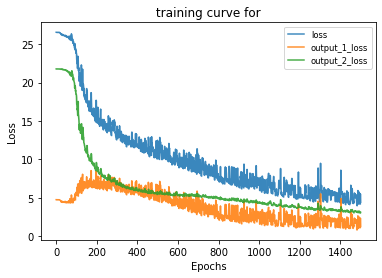

In [14]:
plot_train_test_loss([hist]);